**// IMPORTS**

In [1]:
# --- SETUP / CONNECT ---
import duckdb, pathlib, pandas as pd, re, numpy as np
from collections import Counter
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

DB_PATH      = '../data/duckdb/subs_project.duckdb'
TRAIN_TABLE  = 'main.train_data'
TEST_TABLE   = 'main.test_data'

# sampling knobs
N_RATIO_SAMPLE   = 500_000
N_SCATTER_SAMPLE = 50_000
N_TEXT_SAMPLE    = 10_000

con = duckdb.connect(DB_PATH)
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA preserve_insertion_order=false;")
# con.execute("PRAGMA memory_limit='4GB';")  # optional cap

# (Only needed if your train/test views reference `src`)
# from pathlib import Path
# SRC_DB = Path('../data/duckdb/subs.duckdb').as_posix()
# if 'src' not in con.execute("PRAGMA database_list").df()['name'].tolist():
#     con.execute(f"ATTACH '{SRC_DB}' AS src;")

def both_sides(where_extra: str = "") -> str:
    """Return a UNION ALL of train & test selecting the two text columns with optional extra WHERE."""
    extra = f" AND {where_extra}" if where_extra else ""
    return f"""
      SELECT text_pt_br, text_pt_pt FROM {TRAIN_TABLE}
      WHERE text_pt_br IS NOT NULL AND text_pt_pt IS NOT NULL{extra}
      UNION ALL
      SELECT text_pt_br, text_pt_pt FROM {TEST_TABLE}
      WHERE text_pt_br IS NOT NULL AND text_pt_pt IS NOT NULL{extra}
    """


**// CONFIGS**

In [2]:
# --- SAFE ATTACH + OOM-SAFE COUNTS ---
import duckdb, pandas as pd, pathlib
pd.set_option("display.max_colwidth", None)

DB_PROJECT = pathlib.Path("../data/duckdb/subs_project.duckdb").as_posix()
DB_SOURCE  = pathlib.Path("../data/duckdb/subs.duckdb").as_posix()  # holds ptbrvarid etc.

TRAIN_TABLE = "main.train_data"
TEST_TABLE  = "main.test_data"

con = duckdb.connect(DB_PROJECT)
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA preserve_insertion_order=false;")

# Attach 'src' if missing (train/test views often reference it)
dbl = con.execute("PRAGMA database_list").df()
if not (dbl["name"] == "src").any():
    con.execute(f"ATTACH '{DB_SOURCE}' AS src;")

# -------- Per-dataset counts (do each split separately to avoid huge unions) --------
train_ds = con.execute(f"""
    SELECT dataset, COUNT(*) AS n
    FROM {TRAIN_TABLE}
    GROUP BY dataset
""").fetchdf()

test_ds = con.execute(f"""
    SELECT dataset, COUNT(*) AS n
    FROM {TEST_TABLE}
    GROUP BY dataset
""").fetchdf()

per_dataset = (
    pd.concat([train_ds.assign(split="train"), test_ds.assign(split="test")], ignore_index=True)
      .groupby("dataset", as_index=False)["n"].sum()
      .sort_values("n", ascending=False)
)

# -------- Totals & diagnostics (per split, then sum in pandas) --------
train_tot = con.execute(f"""
    SELECT
      COUNT(*) AS total_rows,
      SUM(dataset IS NULL) AS null_dataset,
      SUM(COALESCE(TRIM(text_pt_br),'')='' AND COALESCE(TRIM(text_pt_pt),'')='') AS both_texts_empty_or_null
    FROM {TRAIN_TABLE}
""").fetchdf().iloc[0]

test_tot = con.execute(f"""
    SELECT
      COUNT(*) AS total_rows,
      SUM(dataset IS NULL) AS null_dataset,
      SUM(COALESCE(TRIM(text_pt_br),'')='' AND COALESCE(TRIM(text_pt_pt),'')='') AS both_texts_empty_or_null
    FROM {TEST_TABLE}
""").fetchdf().iloc[0]

totals = pd.DataFrame([{
    "total_rows": int(train_tot["total_rows"] + test_tot["total_rows"]),
    "rows_with_null_dataset": int(train_tot["null_dataset"] + test_tot["null_dataset"]),
    "rows_with_both_texts_empty_or_null": int(train_tot["both_texts_empty_or_null"] + test_tot["both_texts_empty_or_null"]),
}])

per_split = pd.DataFrame([
    {"split":"train",
     "total_rows": int(train_tot["total_rows"]),
     "rows_with_null_dataset": int(train_tot["null_dataset"]),
     "rows_with_both_texts_empty_or_null": int(train_tot["both_texts_empty_or_null"])},
    {"split":"test",
     "total_rows": int(test_tot["total_rows"]),
     "rows_with_null_dataset": int(test_tot["null_dataset"]),
     "rows_with_both_texts_empty_or_null": int(test_tot["both_texts_empty_or_null"])},
])

print("=== Rows per dataset (combined) ==="); display(per_dataset)
print("\n=== Totals & null/empty diagnostics (combined) ==="); display(totals)
print("\n=== Per-split diagnostics (optional) ==="); display(per_split)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

=== Rows per dataset (combined) ===


,dataset,n
2,OpenSubs,10347883
3,PtBrVarId,2990689
0,FRMT,5129
1,Gold,500



=== Totals & null/empty diagnostics (combined) ===


,total_rows,rows_with_null_dataset,rows_with_both_texts_empty_or_null
0,13344201,0,0



=== Per-split diagnostics (optional) ===


,split,total_rows,rows_with_null_dataset,rows_with_both_texts_empty_or_null
0,train,12743162,0,0
1,test,601039,0,0


**// MAIN CODE**

In [3]:
print("=== BASIC INFO (whole dataset) ===")
info = con.execute(f"""
SELECT
  COUNT(*) AS total_rows,
  COUNT(DISTINCT text_pt_br) AS unique_br,
  COUNT(DISTINCT text_pt_pt) AS unique_pt
FROM (
  SELECT text_pt_br, text_pt_pt FROM {TRAIN_TABLE}
  UNION ALL
  SELECT text_pt_br, text_pt_pt FROM {TEST_TABLE}
) a;
""").fetchdf()
display(info)

basic = con.execute(f"""
SELECT
  COUNT(*)                                     AS total_rows,
  SUM(text_pt_br IS NULL)                      AS null_br,
  SUM(text_pt_pt IS NULL)                      AS null_pt,
  SUM(COALESCE(TRIM(text_pt_br),'')='')        AS empty_br,
  SUM(COALESCE(TRIM(text_pt_pt),'')='')        AS empty_pt,
  COUNT(DISTINCT text_pt_br)                   AS unique_br_raw,
  COUNT(DISTINCT text_pt_pt)                   AS unique_pt_raw
FROM (
  SELECT text_pt_br, text_pt_pt FROM {TRAIN_TABLE}
  UNION ALL
  SELECT text_pt_br, text_pt_pt FROM {TEST_TABLE}
) a;
""").fetchdf()

norm = con.execute(f"""
WITH n AS (
  {both_sides()}
)
SELECT
  COUNT(*) AS rows_2sides,
  COUNT(DISTINCT LOWER(TRIM(REGEXP_REPLACE(text_pt_br,'\\s+',' ')))) AS unique_br_norm,
  COUNT(DISTINCT LOWER(TRIM(REGEXP_REPLACE(text_pt_pt,'\\s+',' ')))) AS unique_pt_norm,
  COUNT(DISTINCT
         LOWER(TRIM(REGEXP_REPLACE(text_pt_br,'\\s+',' '))) || CHR(31) ||
         LOWER(TRIM(REGEXP_REPLACE(text_pt_pt,'\\s+',' ')))
       ) AS unique_pairs_norm,
  COUNT(*) -
  COUNT(DISTINCT
         LOWER(TRIM(REGEXP_REPLACE(text_pt_br,'\\s+',' '))) || CHR(31) ||
         LOWER(TRIM(REGEXP_REPLACE(text_pt_pt,'\\s+',' ')))
       ) AS dup_pairs_norm
FROM n;
""").fetchdf()

display(pd.concat([basic, norm], axis=1))


=== BASIC INFO (whole dataset) ===


OutOfMemoryException: Out of Memory Error: failed to pin block of size 256.0 KiB (5.9 GiB/5.9 GiB used)

Possible solutions:
* Reducing the number of threads (SET threads=X)
* Disabling insertion-order preservation (SET preserve_insertion_order=false)
* Increasing the memory limit (SET memory_limit='...GB')

See also https://duckdb.org/docs/stable/guides/performance/how_to_tune_workloads

In [ ]:
print("\n=== LENGTH STATS (chars) ===")
lengths = con.execute(f"""
SELECT
  LENGTH(text_pt_br) AS len_br,
  LENGTH(text_pt_pt) AS len_pt
FROM (
  {both_sides()}
) a;
""").fetchdf()
display(lengths.describe())

plt.figure()
plt.hist(lengths["len_br"], bins=1000)
plt.title("PT-BR length distribution (train+test)")
plt.xlabel("Characters"); plt.ylabel("Frequency")
plt.show()



=== LENGTH STATS (chars) ===


RuntimeError: Query interrupted

In [ ]:
concat = pd.concat([basic, norm], axis=1)
concat

,total_rows,null_br,null_pt,empty_br,empty_pt,unique_br_raw,unique_pt_raw,rows_2sides,unique_br_norm,unique_pt_norm,unique_pairs_norm,dup_pairs_norm
0,10510013,0.0,0.0,0.0,0.0,9461055,9495300,10510013,9447883,9483033,10487155,22858



=== LENGTH STATS ===
             len_br        len_pt
count  1.051001e+07  1.051001e+07
mean   3.972676e+01  3.991568e+01
std    3.028665e+01  3.034423e+01
min    1.000000e+00  1.000000e+00
25%    2.100000e+01  2.100000e+01
50%    3.100000e+01  3.100000e+01
75%    4.900000e+01  5.000000e+01
max    2.804000e+03  2.778000e+03


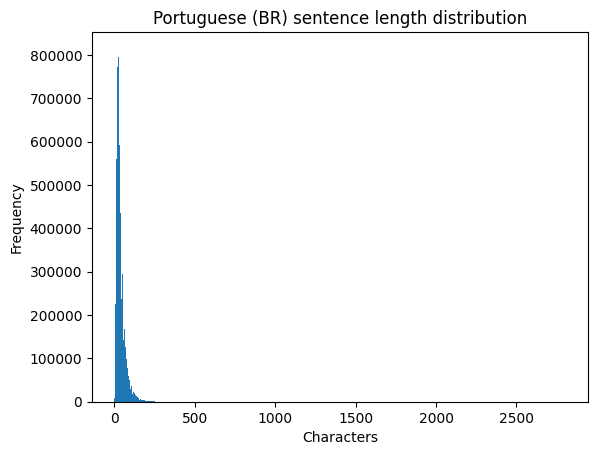

,len_br,len_pt
0,244,239
1,12,9
2,33,24
3,14,13
4,81,92
...,...,...
10510008,29,29
10510009,72,69
10510010,52,49
10510011,42,35


In [ ]:
# ratio stats
ratio_stats = con.execute(f"""
WITH L AS (
  SELECT
    LENGTH(text_pt_br) AS lb,
    LENGTH(text_pt_pt) AS lp
  FROM (
    {both_sides("LENGTH(text_pt_br) > 0")}
  ) a
)
SELECT
  COUNT(*)                                                   AS n_rows,
  AVG(lp::DOUBLE / lb)                                       AS avg_ratio,
  QUANTILE_CONT(lp::DOUBLE / lb, 0.50)                       AS median_ratio,
  SUM(CASE WHEN (lp::DOUBLE / lb) BETWEEN 0.80 AND 1.25 THEN 1 ELSE 0 END) AS n_strict_ok,
  SUM(CASE WHEN (lp::DOUBLE / lb) BETWEEN 0.50 AND 2.00 THEN 1 ELSE 0 END) AS n_loose_ok,
  SUM(CASE WHEN (lp::DOUBLE / lb) < 0.50 OR (lp::DOUBLE / lb) > 2.00 THEN 1 ELSE 0 END) AS n_outliers,
  CORR(lb, lp)                                               AS corr_len
FROM L;
""").fetchdf()

n_rows = int(ratio_stats.loc[0, "n_rows"])
ratio_stats["pct_strict_ok"] = ratio_stats["n_strict_ok"] / n_rows
ratio_stats["pct_loose_ok"]  = ratio_stats["n_loose_ok"]  / n_rows
ratio_stats["pct_outliers"]  = ratio_stats["n_outliers"]  / n_rows
display(ratio_stats)

# ratio histogram (sampled per split, then UNION ALL)
ratio_sample = con.execute(f"""
SELECT (LENGTH(text_pt_pt)::DOUBLE / NULLIF(LENGTH(text_pt_br),0)) AS ratio
FROM {TRAIN_TABLE}
WHERE text_pt_br IS NOT NULL AND text_pt_pt IS NOT NULL AND LENGTH(text_pt_br) > 0
USING SAMPLE {N_RATIO_SAMPLE//2} ROWS
UNION ALL
SELECT (LENGTH(text_pt_pt)::DOUBLE / NULLIF(LENGTH(text_pt_br),0)) AS ratio
FROM {TEST_TABLE}
WHERE text_pt_br IS NOT NULL AND text_pt_pt IS NOT NULL AND LENGTH(text_pt_br) > 0
USING SAMPLE {N_RATIO_SAMPLE//2} ROWS;
""").fetchdf()

plt.figure(figsize=(8,5))
plt.hist(ratio_sample["ratio"].dropna(), bins=150)
plt.title("Distribution of Length Ratios (len_pt / len_br) — sampled train+test")
plt.xlim(0, 4)
plt.xlabel("Ratio"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

# scatter sample (per split, then union)
scatter_sample = con.execute(f"""
SELECT LENGTH(text_pt_br) AS len_br, LENGTH(text_pt_pt) AS len_pt
FROM {TRAIN_TABLE}
WHERE text_pt_br IS NOT NULL AND text_pt_pt IS NOT NULL
USING SAMPLE {N_SCATTER_SAMPLE//2} ROWS
UNION ALL
SELECT LENGTH(text_pt_br) AS len_br, LENGTH(text_pt_pt) AS len_pt
FROM {TEST_TABLE}
WHERE text_pt_br IS NOT NULL AND text_pt_pt IS NOT NULL
USING SAMPLE {N_SCATTER_SAMPLE//2} ROWS;
""").fetchdf()

plt.figure(figsize=(6,6))
plt.scatter(scatter_sample["len_br"], scatter_sample["len_pt"], s=2, alpha=0.15)
plt.title("Sentence-length Correlation — sampled train+test")
plt.xlabel("len_br"); plt.ylabel("len_pt")
plt.tight_layout(); plt.show()


In [ ]:
def tokenize(text):
    return re.findall(r"\b\w+\b", str(text).lower())

sample_texts = con.execute(f"""
SELECT text_pt_br, text_pt_pt
FROM (
  SELECT text_pt_br, text_pt_pt FROM {TRAIN_TABLE} USING SAMPLE {N_TEXT_SAMPLE//2} ROWS
  UNION ALL
  SELECT text_pt_br, text_pt_pt FROM {TEST_TABLE} USING SAMPLE {N_TEXT_SAMPLE//2} ROWS
) a;
""").fetchdf()

tokens_br, tokens_pt = [], []
for _, row in sample_texts.iterrows():
    if row.text_pt_br: tokens_br += tokenize(row.text_pt_br)
    if row.text_pt_pt: tokens_pt += tokenize(row.text_pt_pt)

vocab_br, vocab_pt = set(tokens_br), set(tokens_pt)

print("\n=== VOCABULARY (sampled) ===")
print(f"Total tokens (BR): {len(tokens_br):,}")
print(f"Unique tokens (BR): {len(vocab_br):,}")
print(f"TTR (BR): {len(vocab_br)/max(1,len(tokens_br)):.4f}")
print(f"Total tokens (PT): {len(tokens_pt):,}")
print(f"Unique tokens (PT): {len(vocab_pt):,}")
print(f"TTR (PT): {len(vocab_pt)/max(1,len(tokens_pt)):.4f}")

print("\nTop 20 BR words:")
for w,c in Counter(tokens_br).most_common(20):
    print(f"{w:>12} : {c}")


In [ ]:
def outlier_counts_union(ratio_low=0.50, ratio_high=2.00):
    return con.execute(f"""
    WITH r AS (
      SELECT
        (LENGTH(text_pt_pt)::DOUBLE / NULLIF(LENGTH(text_pt_br),0)) AS ratio
      FROM ({both_sides("LENGTH(text_pt_br) > 0")}) a
    )
    SELECT
      COUNT(*) AS n_rows,
      SUM(ratio < {ratio_low})  AS n_low,
      SUM(ratio > {ratio_high}) AS n_high,
      SUM(ratio < {ratio_low} OR ratio > {ratio_high}) AS n_outliers,
      ROUND(100.0 * SUM(ratio < {ratio_low} OR ratio > {ratio_high}) / COUNT(*), 3) AS pct_outliers
    FROM r;
    """).fetchdf()

def outlier_examples_union(ratio_low=0.50, ratio_high=2.00, limit_each_side=500):
    return con.execute(f"""
    WITH r AS (
      SELECT
        text_pt_br, text_pt_pt,
        LENGTH(text_pt_br) AS len_br,
        LENGTH(text_pt_pt) AS len_pt,
        (LENGTH(text_pt_pt)::DOUBLE / NULLIF(LENGTH(text_pt_br),0)) AS ratio
      FROM ({both_sides("LENGTH(text_pt_br) > 0")}) a
    ),
    lo AS (
      SELECT 'low_ratio' AS kind, * FROM r WHERE ratio < {ratio_low} ORDER BY ratio ASC LIMIT {limit_each_side}
    ),
    hi AS (
      SELECT 'high_ratio' AS kind, * FROM r WHERE ratio > {ratio_high} ORDER BY ratio DESC LIMIT {limit_each_side}
    )
    SELECT * FROM lo UNION ALL SELECT * FROM hi;
    """).fetchdf()

print("\n=== Outlier counts (union) ===")
display(outlier_counts_union(0.5, 2.0))

print("\n=== Outlier examples (head) ===")
display(outlier_examples_union(0.5, 2.0, 200).head(10))
